In [ ]:
# in Section A, replace the deps line with:
!pip -q install -U rasterio tqdm scikit-learn tensorflow

# A Mount + imports + paths

In [ ]:
# ===== Mount Google Drive =====
import os
from google.colab import drive

MOUNT = '/content/gdrive'
os.makedirs(MOUNT, exist_ok=True)
drive.mount(MOUNT, force_remount=True)
print("Drive mounted?", os.path.exists(MOUNT))

# ===== Project roots =====
ROOT = "/content/gdrive/MyDrive/AA_GEOG_proj_training"
DATASETS = [
    "patches_less_polygons",
    "patches_more_polygons",
]
OUT_DIR = f"{ROOT}/outputs_models"
os.makedirs(OUT_DIR, exist_ok=True)

# ===== Constants =====
WIN    = 64
STRIDE = 32
SEED   = 42
SEAGRASS_CLASS_ID = 4  # <-- change after inspecting printed labels if needed

Mounted at /content/gdrive
Drive mounted? True


In [ ]:
# ===== Deps =====
import glob, numpy as np, rasterio
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
np.random.seed(SEED); tf.random.set_seed(SEED)


# B) Load chips from both folders → X, Y

In [ ]:
# ==== Build X and Y from both patch folders if they don't exist ====
import os, glob, numpy as np, rasterio
from pathlib import Path
from tqdm import tqdm

# Expect ROOT set earlier; fallback if missing
ROOT = globals().get("ROOT", "/content/gdrive/MyDrive/AA_GEOG_proj_training")
DATASETS = ["patches_less_polygons", "patches_more_polygons"]
WIN = 64
IMG_EXTS = (".tif", ".tiff")

def read_img(fp):
    with rasterio.open(fp) as src:
        arr = src.read().astype(np.float32)    # (C,H,W)
        nd = src.nodata
    if nd is not None:
        arr = np.where(arr == nd, np.nan, arr)
    return np.moveaxis(arr, 0, -1)            # -> (H,W,C)

def read_lbl(fp):
    with rasterio.open(fp) as src:
        lbl = src.read(1).astype(np.int32)    # (H,W)
        nd = src.nodata
    if nd is not None:
        lbl = np.where(lbl == nd, 255, lbl)   # 255 = ignore
    return lbl

def pairs_from_map(map_txt, dataset_root):
    pairs = []
    with open(map_txt, "r") as f:
        for line in f:
            line = line.strip()
            if not line: continue
            img_rel, lbl_rel = line.split()
            img_fp = os.path.join(dataset_root, img_rel.replace("\\","/"))
            lbl_fp = os.path.join(dataset_root, lbl_rel.replace("\\","/"))
            pairs.append((img_fp, lbl_fp))
    return pairs

def pairs_by_basenames(img_dir, lbl_dir):
    imgs = {Path(p).stem: p for p in glob.glob(str(Path(img_dir) / "*")) if Path(p).suffix.lower() in IMG_EXTS}
    lbls = {Path(p).stem: p for p in glob.glob(str(Path(lbl_dir) / "*")) if Path(p).suffix.lower() in IMG_EXTS}
    common = sorted(set(imgs) & set(lbls))
    return [(imgs[s], lbls[s]) for s in common]

if 'X' not in globals() or 'Y' not in globals():
    all_pairs = []
    for ds in DATASETS:
        ds_root = f"{ROOT}/{ds}"
        img_dir = f"{ds_root}/images"
        lbl_dir = f"{ds_root}/labels"
        map_txt = f"{ds_root}/map.txt"
        pairs = pairs_from_map(map_txt, ds_root) if os.path.exists(map_txt) else pairs_by_basenames(img_dir, lbl_dir)
        print(f"{ds}: {len(pairs)} pairs")
        all_pairs.extend(pairs)

    assert all_pairs, "No image/label pairs found. Check ROOT and folder structure."

    X_list, Y_list = [], []
    for img_fp, lbl_fp in tqdm(all_pairs, desc="Loading chips"):
        x = read_img(img_fp)
        y = read_lbl(lbl_fp)
        if x.shape[:2] != (WIN, WIN) or y.shape[:2] != (WIN, WIN):
            raise ValueError(f"Tile size mismatch: {img_fp} {x.shape[:2]} / {lbl_fp} {y.shape[:2]} expected {(WIN,WIN)}")
        X_list.append(np.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0))
        Y_list.append(y)

    X = np.stack(X_list, axis=0)   # (N,64,64,C)
    Y = np.stack(Y_list, axis=0)   # (N,64,64)

print("X:", X.shape, "Y:", Y.shape, "unique Y:", np.unique(Y))


patches_less_polygons: 116 pairs
patches_more_polygons: 50 pairs


Loading chips: 100%|██████████| 166/166 [00:56<00:00,  2.92it/s]


X: (166, 64, 64, 12) Y: (166, 64, 64) unique Y: [0 1 2 3 4 5]


In [ ]:
# ==== Build Y_bin, make stratified splits, compute pos_weight, set INPUT_SHAPE ====
import numpy as np

# 0) Preconditions
assert 'X' in locals() and 'Y' in locals(), "Run the loader cell first to define X and Y."

# 1) Configs
SEED = 42 if 'SEED' not in locals() else SEED
SEAGRASS_CLASS_ID = locals().get('SEAGRASS_CLASS_ID', 4)  # change if needed
IGNORE_VALUE = 255  # unlabeled in masks (if present)

# 2) Binary mask (seagrass vs not)
Y_clean = np.where(Y == IGNORE_VALUE, 0, Y)                 # ignore -> background
Y_bin   = (Y_clean == SEAGRASS_CLASS_ID).astype("float32")[..., None]  # (N,64,64,1)

print("Unique raw label ids in Y:", np.unique(Y))
print("Y_bin -> positives:", int(Y_bin.sum()), "of", Y_bin.size, f"({Y_bin.mean():.6f} fraction)")

# 3) Stratified split by tile positivity (ensures positives in each split if available)
tile_pos_frac = Y_bin.reshape(len(Y_bin), -1).mean(axis=1)
has_pos = tile_pos_frac > 0
print(f"Tiles with ANY seagrass: {int(has_pos.sum())}/{len(has_pos)}")

def stratified_split_by_tilepos(tile_has_pos, test_ratio=0.10, val_ratio=0.10, seed=SEED):
    rng = np.random.default_rng(seed)
    pos_idx = np.where(tile_has_pos)[0]; rng.shuffle(pos_idx)
    neg_idx = np.where(~tile_has_pos)[0]; rng.shuffle(neg_idx)

    def split(idx):
        n = len(idx)
        if n == 0: return np.array([], int), np.array([], int), np.array([], int)
        n_test = max(1, int(test_ratio*n))
        n_val  = max(1, int(val_ratio*(n - n_test)))
        te = idx[:n_test]; va = idx[n_test:n_test+n_val]; tr = idx[n_test+n_val:]
        return tr, va, te

    tr_p, va_p, te_p = split(pos_idx)
    tr_n, va_n, te_n = split(neg_idx)
    tr = np.concatenate([tr_p, tr_n]) if tr_p.size or tr_n.size else np.array([], int)
    va = np.concatenate([va_p, va_n]) if va_p.size or va_n.size else np.array([], int)
    te = np.concatenate([te_p, te_n]) if te_p.size or te_n.size else np.array([], int)
    rng.shuffle(tr); rng.shuffle(va); rng.shuffle(te)
    return tr, va, te

rng = np.random.default_rng(SEED)
if has_pos.any():
    train_idx, val_idx, test_idx = stratified_split_by_tilepos(has_pos, 0.10, 0.10)
else:
    print("WARNING: No positive tiles found — check SEAGRASS_CLASS_ID and labels.")
    idx = rng.permutation(len(X))
    n = len(idx); n_test = int(0.10*n); n_val = int(0.10*(n - n_test))
    test_idx = idx[:n_test]; val_idx = idx[n_test:n_test+n_val]; train_idx = idx[n_test+n_val:]

Xtr, Ytr = X[train_idx], Y_bin[train_idx]
Xva, Yva = X[val_idx],   Y_bin[val_idx]
Xte, Yte = X[test_idx],  Y_bin[test_idx]

def split_stats(name, Ym):
    if len(Ym)==0: return f"{name}: EMPTY"
    tiles_pos = int((Ym.reshape(len(Ym), -1).sum(axis=1) > 0).sum())
    return f"{name}: tiles={len(Ym)}, tiles_with_pos={tiles_pos}, mean_pos_frac={float(Ym.mean()):.6f}"

print(split_stats("Train", Ytr))
print(split_stats("Val",   Yva))
print(split_stats("Test",  Yte))

# 4) Optional: oversample positive tiles if very rare in training
pos_tiles = np.where(Ytr.reshape(len(Ytr), -1).sum(axis=1) > 0)[0]
if len(pos_tiles) > 0:
    ratio = len(pos_tiles) / len(Ytr)
    if ratio < 0.15:
        boost = int(np.ceil(0.15 * len(Ytr) / max(1, len(pos_tiles))))
        extra = np.repeat(pos_tiles, boost)
        Xtr = np.concatenate([Xtr, Xtr[extra]], axis=0)
        Ytr = np.concatenate([Ytr, Ytr[extra]], axis=0)
        print(f"Oversampled positives → train tiles: {len(Xtr)} (ratio ≈ 0.15)")

# 5) Class imbalance weight for WBCE (capped for stability)
pos_pixels = float(Ytr.sum())
neg_pixels = float(Ytr.size - pos_pixels)
pos_weight = float(neg_pixels / max(1.0, pos_pixels))
pos_weight = float(np.clip(pos_weight, 1.0, 100.0))
print(f"pos_weight (neg/pos, capped): {pos_weight:.2f}")

# 6) Define INPUT_SHAPE for model constructors
INPUT_SHAPE = Xtr.shape[1:]
print("INPUT_SHAPE =", INPUT_SHAPE)


Unique raw label ids in Y: [0 1 2 3 4 5]
Y_bin -> positives: 62768 of 679936 (0.092315 fraction)
Tiles with ANY seagrass: 97/166
Train: tiles=137, tiles_with_pos=80, mean_pos_frac=0.091515
Val: tiles=14, tiles_with_pos=8, mean_pos_frac=0.069877
Test: tiles=15, tiles_with_pos=9, mean_pos_frac=0.120557
pos_weight (neg/pos, capped): 9.93
INPUT_SHAPE = (64, 64, 12)


In [ ]:
# per-band normalization, etc.
X_min = np.nanmin(X, axis=(0,1,2), keepdims=True)
X_max = np.nanmax(X, axis=(0,1,2), keepdims=True)
X = (X - X_min) / (X_max - X_min + 1e-6)


# C) Train/val/test split (80/10/10) and targets

In [ ]:
import numpy as np

tile_pos_frac = Y_bin.reshape(len(Y_bin), -1).mean(axis=1)
has_pos = tile_pos_frac > 0
print(f"Tiles with ANY seagrass: {int(has_pos.sum())}/{len(has_pos)}")
if has_pos.any():
    print("Median pos-fraction among positive tiles:", float(np.median(tile_pos_frac[has_pos])))

SEED = 42
def stratified_split_by_tilepos(tile_has_pos, test_ratio=0.10, val_ratio=0.10, seed=SEED):
    rng = np.random.default_rng(seed)
    pos_idx = np.where(tile_has_pos)[0]; rng.shuffle(pos_idx)
    neg_idx = np.where(~tile_has_pos)[0]; rng.shuffle(neg_idx)

    def split(idx_group):
        n = len(idx_group)
        if n == 0: return np.array([],int),np.array([],int),np.array([],int)
        n_test = max(1, int(test_ratio*n))
        n_val  = max(1, int(val_ratio*(n-n_test)))
        te = idx_group[:n_test]; va = idx_group[n_test:n_test+n_val]; tr = idx_group[n_test+n_val:]
        return tr, va, te

    tr_p, va_p, te_p = split(pos_idx)
    tr_n, va_n, te_n = split(neg_idx)
    tr = np.concatenate([tr_p,tr_n]); va = np.concatenate([va_p,va_n]); te = np.concatenate([te_p,te_n])
    rng.shuffle(tr); rng.shuffle(va); rng.shuffle(te)
    return tr, va, te

if has_pos.any():
    train_idx, val_idx, test_idx = stratified_split_by_tilepos(has_pos, 0.10, 0.10)
else:
    print("WARNING: no positive tiles found — check SEAGRASS_CLASS_ID.")
    rng = np.random.default_rng(SEED); idx = rng.permutation(len(X))
    n = len(idx); n_test=int(0.1*n); n_val=int(0.1*(n-n_test))
    test_idx=idx[:n_test]; val_idx=idx[n_test:n_test+n_val]; train_idx=idx[n_test+n_val:]

Xtr, Ytr = X[train_idx], Y_bin[train_idx]
Xva, Yva = X[val_idx],   Y_bin[val_idx]
Xte, Yte = X[test_idx],  Y_bin[test_idx]

def split_stats(name, Ysplit):
    if len(Ysplit)==0: return f"{name}: EMPTY"
    tiles_pos = int((Ysplit.reshape(len(Ysplit), -1).sum(axis=1)>0).sum())
    return f"{name}: tiles={len(Ysplit)} | tiles_with_pos={tiles_pos} | mean_pos_frac={float(Ysplit.mean()):.6f}"

print(split_stats("Train", Ytr))
print(split_stats("Val",   Yva))
print(split_stats("Test",  Yte))

# Optional: oversample positive tiles if super rare
pos_tiles = np.where(Ytr.reshape(len(Ytr), -1).sum(axis=1) > 0)[0]
if len(pos_tiles) > 0:
    ratio = len(pos_tiles)/len(Ytr)
    if ratio < 0.15:
        boost = int(np.ceil(0.15*len(Ytr)/max(1,len(pos_tiles))))
        extra = np.repeat(pos_tiles, boost)
        Xtr = np.concatenate([Xtr, Xtr[extra]], 0)
        Ytr = np.concatenate([Ytr, Ytr[extra]], 0)
        print(f"Oversampled positives → train tiles: {len(Xtr)}")

# Recompute pos_weight safely (cap it to avoid huge weights)
pos_pixels = float(Ytr.sum())
neg_pixels = float(Ytr.size - pos_pixels)
pos_weight = float(neg_pixels / max(1.0, pos_pixels))
pos_weight = float(np.clip(pos_weight, 1.0, 100.0))  # cap for stability
print(f"pos_weight (capped): {pos_weight:.2f}")

# Define INPUT_SHAPE now (prevents NameError)
INPUT_SHAPE = Xtr.shape[1:]
print("INPUT_SHAPE =", INPUT_SHAPE)


Tiles with ANY seagrass: 97/166
Median pos-fraction among positive tiles: 0.14111328125
Train: tiles=137 | tiles_with_pos=80 | mean_pos_frac=0.091515
Val: tiles=14 | tiles_with_pos=8 | mean_pos_frac=0.069877
Test: tiles=15 | tiles_with_pos=9 | mean_pos_frac=0.120557
pos_weight (capped): 9.93
INPUT_SHAPE = (64, 64, 12)


# D) model

3.1 UNet (baseline)

In [ ]:
def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding="same", activation=None, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(f, 3, padding="same", activation=None, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def down_block(x, f):
    c = conv_block(x, f)
    p = layers.MaxPooling2D()(c)
    return c, p

def up_block(x, skip, f):
    x = layers.Conv2DTranspose(f, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, f)
    return x

def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    c1, p1 = down_block(inputs, 32)
    c2, p2 = down_block(p1, 64)
    c3, p3 = down_block(p2, 128)
    c4, p4 = down_block(p3, 256)
    bn = conv_block(p4, 512)
    u1 = up_block(bn, c4, 256)
    u2 = up_block(u1, c3, 128)
    u3 = up_block(u2, c2, 64)
    u4 = up_block(u3, c1, 32)
    out = layers.Conv2D(1, 1, activation="sigmoid")(u4)
    return keras.Model(inputs, out, name="UNet")


3.2 ResUNet (UNet + residual encoder)

In [ ]:
def res_block(x, f, stride=1):
    shortcut = x
    x = layers.Conv2D(f, 3, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
    x = layers.Conv2D(f, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    # match dims
    if shortcut.shape[-1] != f or stride != 1:
        shortcut = layers.Conv2D(f, 1, strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    return x

def down_res(x, f):
    x = res_block(x, f, stride=1)
    p = layers.MaxPooling2D()(x)
    return x, p

def up_res(x, skip, f):
    x = layers.Conv2DTranspose(f, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = res_block(x, f, stride=1)
    return x

def build_resunet(input_shape):
    inputs = layers.Input(shape=input_shape)
    c1, p1 = down_res(inputs, 32)
    c2, p2 = down_res(p1, 64)
    c3, p3 = down_res(p2, 128)
    c4, p4 = down_res(p3, 256)
    bn = res_block(p4, 512)
    u1 = up_res(bn, c4, 256)
    u2 = up_res(u1, c3, 128)
    u3 = up_res(u2, c2, 64)
    u4 = up_res(u3, c1, 32)
    out = layers.Conv2D(1, 1, activation="sigmoid")(u4)
    return keras.Model(inputs, out, name="ResUNet")


3.3 DeepLabV3+ (lite)

In [ ]:
def sep_conv_bn_relu(x, f, k=3, rate=1):
    x = layers.SeparableConv2D(f, k, padding="same", dilation_rate=rate, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_lite(x):
    # simple lightweight encoder to 1/16 resolution
    x = sep_conv_bn_relu(x, 32);      c1 = x           # 1/1
    x = layers.MaxPooling2D()(x)                          # 1/2
    x = sep_conv_bn_relu(x, 64);      c2 = x
    x = layers.MaxPooling2D()(x)                          # 1/4
    x = sep_conv_bn_relu(x, 128);     low = x            # low-level @1/4
    x = layers.MaxPooling2D()(x)                          # 1/8
    x = sep_conv_bn_relu(x, 256)
    x = layers.MaxPooling2D()(x)                          # 1/16
    x = sep_conv_bn_relu(x, 256)
    return x, low

def aspp_lite(x, out_f=256, rates=(1,6,12,18)):
    y = [layers.Conv2D(out_f, 1, padding="same", use_bias=False)(x)]
    y[0] = layers.BatchNormalization()(y[0]); y[0] = layers.Activation("relu")(y[0])
    for r in rates[1:]:
        yy = sep_conv_bn_relu(x, out_f, k=3, rate=r)
        y.append(yy)
    # image pooling branch
    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1,1,int(pool.shape[-1])))(pool)
    pool = layers.Conv2D(out_f, 1, padding="same", use_bias=False)(pool)
    pool = layers.BatchNormalization()(pool); pool = layers.Activation("relu")(pool)
    pool = layers.UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation="bilinear")(pool)
    y.append(pool)
    x = layers.Concatenate()(y)
    x = layers.Conv2D(out_f, 1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation("relu")(x)
    return x

def build_deeplabv3plus_lite(input_shape):
    inputs = layers.Input(shape=input_shape)
    feat, low = encoder_lite(inputs)
    x = aspp_lite(feat, out_f=128, rates=(1,6,12,18))
    x = layers.UpSampling2D(size=4, interpolation="bilinear")(x)  # 1/16 -> 1/4
    low = layers.Conv2D(48, 1, padding="same", use_bias=False)(low)
    low = layers.BatchNormalization()(low); low = layers.Activation("relu")(low)
    x = layers.Concatenate()([x, low])
    x = sep_conv_bn_relu(x, 128)
    x = sep_conv_bn_relu(x, 128)
    x = layers.UpSampling2D(size=4, interpolation="bilinear")(x)  # 1/4 -> 1/1
    out = layers.Conv2D(1, 1, activation="sigmoid")(x)
    return keras.Model(inputs, out, name="DeepLabV3plusLite")


# E) Train helpers (shared)

In [ ]:
import tensorflow as tf
from tensorflow import keras

def weighted_bce_loss(pos_weight: float):
    def loss(y_true, y_pred):
        # clip predictions to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-6, 1.0 - 1e-6)
        y_true = tf.clip_by_value(y_true, 0.0, 1.0)
        loss_pos = -pos_weight * y_true * tf.math.log(y_pred)
        loss_neg = -(1.0 - y_true) * tf.math.log(1.0 - y_pred)
        out = tf.reduce_mean(loss_pos + loss_neg)
        return tf.where(tf.math.is_finite(out), out, tf.constant(0.0, tf.float32))
    return loss

def dice_loss(y_true, y_pred, smooth=1e-6):
    # clip predictions to [0,1] to avoid NaN in multiplications/sums
    y_pred = tf.clip_by_value(y_pred, 1e-6, 1.0 - 1e-6)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2.0 * inter + smooth) / (denom + smooth)
    out = 1.0 - dice
    return tf.where(tf.math.is_finite(out), out, tf.constant(1.0, tf.float32))

def bce_dice_loss(pos_weight, alpha=0.5):
    wbce = weighted_bce_loss(pos_weight)
    def loss(y_true, y_pred):
        l = alpha * wbce(y_true, y_pred) + (1.0 - alpha) * dice_loss(y_true, y_pred)
        return tf.where(tf.math.is_finite(l), l, tf.constant(0.0, tf.float32))
    return loss

# Use a clipped optimizer
from tensorflow import keras

# Option A — global norm clipping (recommended)
opt = keras.optimizers.Adam(
    learning_rate=1e-3,
    amsgrad=True,
    global_clipnorm=1.0,   # <-- keep ONLY this
)

# Option B — per-variable norm clipping (alternative)
# opt = keras.optimizers.Adam(1e-3, amsgrad=True, clipnorm=1.0)

# Option C — clip by absolute value (alternative)
# opt = keras.optimizers.Adam(1e-3, amsgrad=True, clipvalue=0.5)


# opt = keras.optimizers.Adam(1e-3, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
loss_fn = bce_dice_loss(pos_weight, alpha=0.5)

def compile_model(model):
    model.compile(optimizer=opt, loss=loss_fn, metrics=["accuracy"])
    return model


In [ ]:
# def compile_model(model):
#     model.compile(optimizer=keras.optimizers.Adam(1e-3),
#                   loss="binary_crossentropy",
#                   metrics=["accuracy"])
#     return model

def compile_model(model, loss_fn):
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss=loss_fn,
                  metrics=["accuracy"])
    return model


def train_model(model, name, Xtr, Ytr, Xva, Yva, out_dir=OUT_DIR):
    ckpt_path = f"{out_dir}/{name}_best.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_loss"),
        keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor="val_loss"),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
    ]
    history = model.fit(
        Xtr, Ytr, validation_data=(Xva, Yva),
        epochs=50, batch_size=64, callbacks=callbacks, verbose=1
    )
    model.save(f"{out_dir}/{name}_final.keras")
    return ckpt_path, history


# F) Train all three models

In [ ]:
# Quick finite checks on the split arrays
for name, A in [("Xtr", Xtr), ("Ytr", Ytr), ("Xva", Xva), ("Yva", Yva)]:
    assert np.isfinite(A).all(), f"{name} has NaN/Inf"

# Small dry run through one model before full training
tmp_in = tf.convert_to_tensor(Xtr[:2])
tmp_out = tf.convert_to_tensor(Ytr[:2])


In [ ]:
models_to_train = {
    "UNet":             build_unet(INPUT_SHAPE),
    "ResUNet":          build_resunet(INPUT_SHAPE),
    "DeepLabV3plusLite":build_deeplabv3plus_lite(INPUT_SHAPE),
}

ckpts = {}
for name, mdl in models_to_train.items():
    print("\n==============================")
    print(f"Training {name}")
    # compile_model(mdl)  old code
    loss_fn = bce_dice_loss(pos_weight, alpha=0.5)
    compile_model(mdl, loss_fn)

    ckpt_path, hist = train_model(mdl, name, Xtr, Ytr, Xva, Yva)
    ckpts[name] = ckpt_path
    print(f"{name}: best weights at {ckpt_path}")



Training UNet
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.6028 - loss: 0.9554 - val_accuracy: 0.8417 - val_loss: 1.0003 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.7263 - loss: 0.7243 - val_accuracy: 0.9244 - val_loss: 0.9985 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.7838 - loss: 0.6685 - val_accuracy: 0.9288 - val_loss: 0.9985 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.8228 - loss: 0.6362 - val_accuracy: 0.9203 - val_loss: 1.0031 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8694 - loss: 0.5972
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.8698 - loss: 0.5973 - val_accuracy: 0.9196 - val_loss: 1.0026 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8919 - loss: 0.5645 - val_accuracy: 0

# G) Evaluate on the held-out test set (and compare)

In [ ]:
def best_threshold_on_val(model, Xv, Yv):
    pr = model.predict(Xv, batch_size=64, verbose=0)[...,0]
    gt = (Yv[...,0] > 0.5).astype(np.uint8)
    best_t, best_f1 = 0.5, -1
    for t in np.linspace(0.05, 0.95, 19):
        pm = (pr >= t).astype(np.uint8)
        tp = (pm & gt).sum(); fp = (pm & (1-gt)).sum(); fn = ((1-pm) & gt).sum()
        prec = tp / (tp + fp + 1e-6); rec = tp / (tp + fn + 1e-6)
        f1 = 2*prec*rec / (prec + rec + 1e-6)
        if f1 > best_f1: best_f1, best_t = f1, float(t)
    return best_t, best_f1

val_thresholds = {}
for name, ck in ckpts.items():
    mdl = keras.models.load_model(ck, compile=False)
    t, f1v = best_threshold_on_val(mdl, Xva, Yva)
    val_thresholds[name] = t
    print(f"{name}: best val threshold={t:.2f}, val F1={f1v:.4f}")


UNet: best val threshold=0.05, val F1=0.1306
ResUNet: best val threshold=0.45, val F1=0.1606
DeepLabV3plusLite: best val threshold=0.05, val F1=0.1306


In [ ]:
def evaluate_model(ckpt_path, name, threshold):
    mdl = keras.models.load_model(ckpt_path, compile=False)
    pr = mdl.predict(Xte, batch_size=64, verbose=0)[...,0]
    pm = (pr >= threshold).astype(np.uint8)
    gt = (Yte[...,0] > 0.5).astype(np.uint8)
    eps = 1e-6
    tp = int((pm & gt).sum()); fp = int((pm & (1-gt)).sum())
    fn = int(((1-pm) & gt).sum()); tn = int(((1-pm) & (1-gt)).sum())
    precision = tp / (tp + fp + eps); recall = tp / (tp + fn + eps)
    f1 = 2*precision*recall / (precision + recall + eps)
    iou = tp / (tp + fp + fn + eps); acc = (tp + tn) / (tp + tn + fp + fn + eps)
    return {"model": name, "acc": acc, "precision": precision, "recall": recall, "f1": f1, "iou": iou, "thr": threshold}

results = []
for name, ck in ckpts.items():
    t = val_thresholds[name]
    print(f"Evaluating {name} with threshold {t:.2f} ...")
    results.append(evaluate_model(ck, name, t))

print("\n=== Test set comparison (thresholds from validation) ===")
print(f"{'Model':20} {'Thr':>5} {'Acc':>8} {'Prec':>8} {'Rec':>8} {'F1':>8} {'IoU':>8}")
for r in results:
    print(f"{r['model']:20} {r['thr']:>5.2f} {r['acc']:>8.4f} {r['precision']:>8.4f} {r['recall']:>8.4f} {r['f1']:>8.4f} {r['iou']:>8.4f}")


Evaluating UNet with threshold 0.05 ...
Evaluating ResUNet with threshold 0.45 ...


Evaluating DeepLabV3plusLite with threshold 0.05 ...



=== Test set comparison (thresholds from validation) ===
Model                  Thr      Acc     Prec      Rec       F1      IoU
UNet                  0.05   0.1206   0.1206   1.0000   0.2152   0.1206
ResUNet               0.45   0.2601   0.1395   0.9943   0.2447   0.1394
DeepLabV3plusLite     0.05   0.1206   0.1206   1.0000   0.2152   0.1206


In [ ]:
# --- Diagnostics: class balance and split sanity ---
# Fraction of positive pixels per tile
tile_pos_frac = Y_bin.reshape(len(Y_bin), -1).mean(axis=1)
print("Tiles with ANY seagrass pixels:", int((tile_pos_frac>0).sum()), "/", len(tile_pos_frac))
print("Median positive fraction per *positive* tile:", float(np.median(tile_pos_frac[tile_pos_frac>0])) if (tile_pos_frac>0).any() else 0.0)

# If this prints 0 for "Tiles with ANY seagrass", your SEAGRASS_CLASS_ID is wrong.
# Verify:
print("Unique raw label ids:", np.unique(Y))


Tiles with ANY seagrass pixels: 97 / 166
Median positive fraction per *positive* tile: 0.14111328125
Unique raw label ids: [0 1 2 3 4 5]


# Full-scene prediction helper (use the best model)

In [ ]:
# # ===== OPTIONAL: Predict a full scene and write rasters =====
# import rasterio
# from tqdm import tqdm

FULL_SCENE_TIF = f"{ROOT}/whanganui_cropped.tif"  # set your scene path
BEST_MODEL = best["model"]
BEST_CKPT  = ckpts[BEST_MODEL]

# load model
model = keras.models.load_model(BEST_CKPT, compile=False)

# helper to cover edges fully
def steps(size, win, stride):
    s = list(range(0, size - win + 1, stride))
    if s[-1] != size - win:
        s.append(size - win)
    return s

with rasterio.open(FULL_SCENE_TIF) as src:
    H, W = src.height, src.width
    profile = src.profile
    full = src.read().astype(np.float32)  # (C,H,W)
# normalize with training mins/maxs
mins = X_min.squeeze(); maxs = X_max.squeeze()
if full.shape[0] != mins.shape[0]:
    raise ValueError(f"Scene has {full.shape[0]} bands, chips have {mins.shape[0]}. Align band count/order.")
full_norm = (full - mins[:,None,None]) / (maxs[:,None,None] - mins[:,None,None] + 1e-6)

prob = np.zeros((H, W), dtype=np.float32)
count = np.zeros((H, W), dtype=np.uint16)
ys = steps(H, WIN, STRIDE); xs = steps(W, WIN, STRIDE)

for y in tqdm(ys, desc="Rows"):
    chips, locs = [], []
    for x in xs:
        chip = full_norm[:, y:y+WIN, x:x+WIN]
        chip = np.moveaxis(chip, 0, -1)[None, ...]  # (1,64,64,C)
        chips.append(chip); locs.append((y,x))
    batch = np.concatenate(chips, axis=0)
    p = model.predict(batch, verbose=0)[...,0]
    for (yy,xx), p_i in zip(locs, p):
        prob[yy:yy+WIN, xx:xx+WIN] += p_i
        count[yy:yy+WIN, xx:xx+WIN] += 1

count[count==0] = 1
prob = prob / count
hard = (prob >= 0.5).astype(np.uint8)

cov_prof = profile.copy(); cov_prof.update(count=1, dtype="float32")
cls_prof = profile.copy(); cls_prof.update(count=1, dtype="uint8")
COVERAGE_TIF = f"{OUT_DIR}/{BEST_MODEL}_coverage_prob.tif"
CLASS_TIF    = f"{OUT_DIR}/{BEST_MODEL}_coverage_class.tif"
with rasterio.open(COVERAGE_TIF, "w", **cov_prof) as dst: dst.write(prob, 1)
with rasterio.open(CLASS_TIF, "w", **cls_prof) as dst:   dst.write(hard, 1)
print("Saved:", COVERAGE_TIF, "and", CLASS_TIF)


NameError: name 'best' is not defined

# Performance for Report

,acc,precision,recall,f1,iou,thr
model,,,,,,
UNet,0.120557,0.120557,1.00000,0.215173,0.120557,0.05
ResUNet,0.260124,0.139539,0.99433,0.244733,0.139428,0.45
DeepLabV3plusLite,0.120557,0.120557,1.00000,0.215173,0.120557,0.05


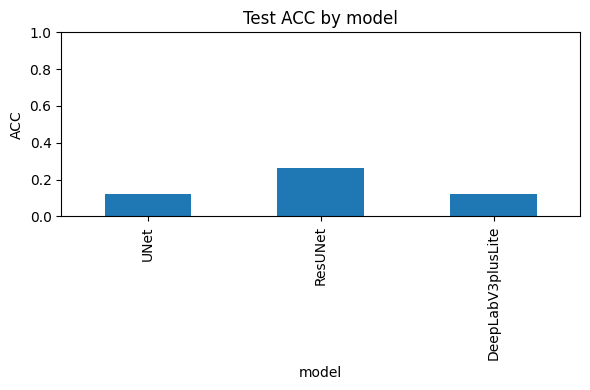

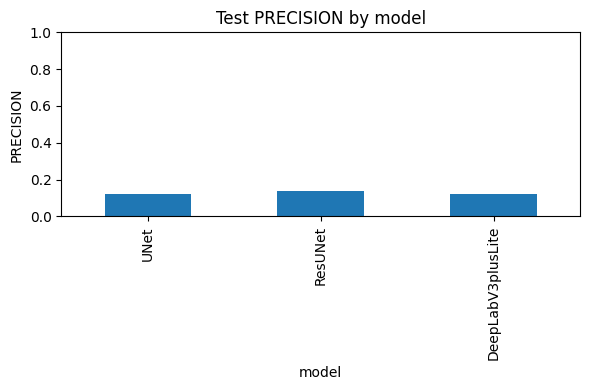

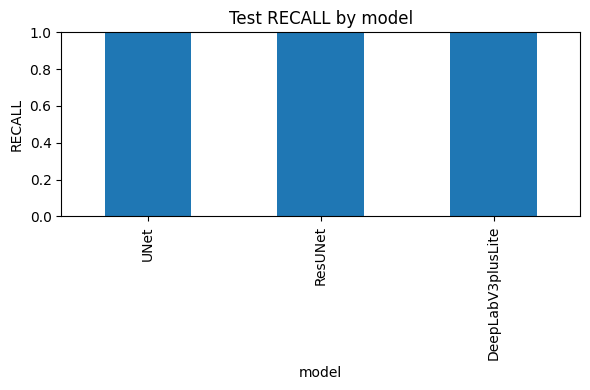

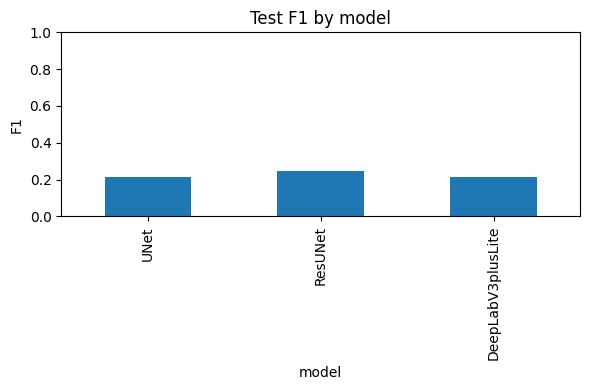

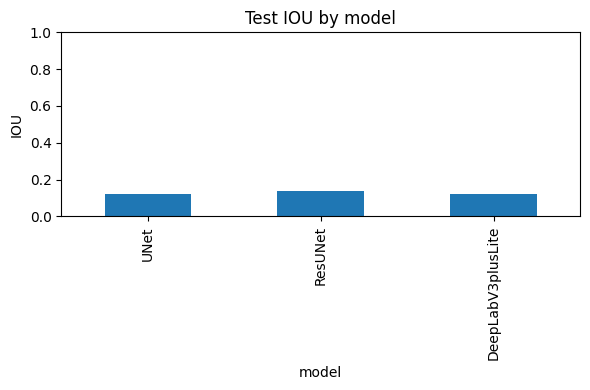

In [ ]:
# === Side-by-side metrics table + bar charts ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

df = pd.DataFrame(results).set_index("model")
display(df)

# --- Bar charts for Acc / Prec / Rec / F1 / IoU ---
metrics = ["acc", "precision", "recall", "f1", "iou"]
for m in metrics:
    plt.figure(figsize=(6,4))
    df[m].plot(kind="bar")
    plt.title(f"Test {m.upper()} by model")
    plt.ylabel(m.upper())
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


In [ ]:
# === ROC and PR curves ===
!pip -q install scikit-learn
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow import keras

def flatten_gt_pred(model_path, X, Y):
    """Return flattened arrays: y_true (0/1), y_score (prob) over all test pixels."""
    mdl = keras.models.load_model(model_path, compile=False)
    pr = mdl.predict(X, batch_size=64, verbose=0)[...,0]      # (N,H,W)
    y_score = pr.reshape(-1)
    y_true  = (Y[...,0] > 0.5).astype(np.uint8).reshape(-1)   # (N,H,W,1) -> (-1,)
    return y_true, y_score

roc_data = {}
pr_data  = {}
for name, ck in ckpts.items():
    y_true, y_score = flatten_gt_pred(ck, Xte, Yte)
    # Guard: remove NaNs/Infs if any
    m = np.isfinite(y_score)
    y_true, y_score = y_true[m], y_score[m]
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score) if len(np.unique(y_true))>1 else np.nan
    roc_data[name] = (fpr, tpr, auc)
    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score) if len(np.unique(y_true))>1 else np.nan
    pr_data[name] = (prec, rec, ap)

# Plot ROC
plt.figure(figsize=(6,5))
for name,(fpr,tpr,auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (pixel-wise, test set)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot PR
plt.figure(figsize=(6,5))
for name,(prec,rec,ap) in pr_data.items():
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves (pixel-wise, test set)")
plt.legend()
plt.tight_layout()
plt.show()


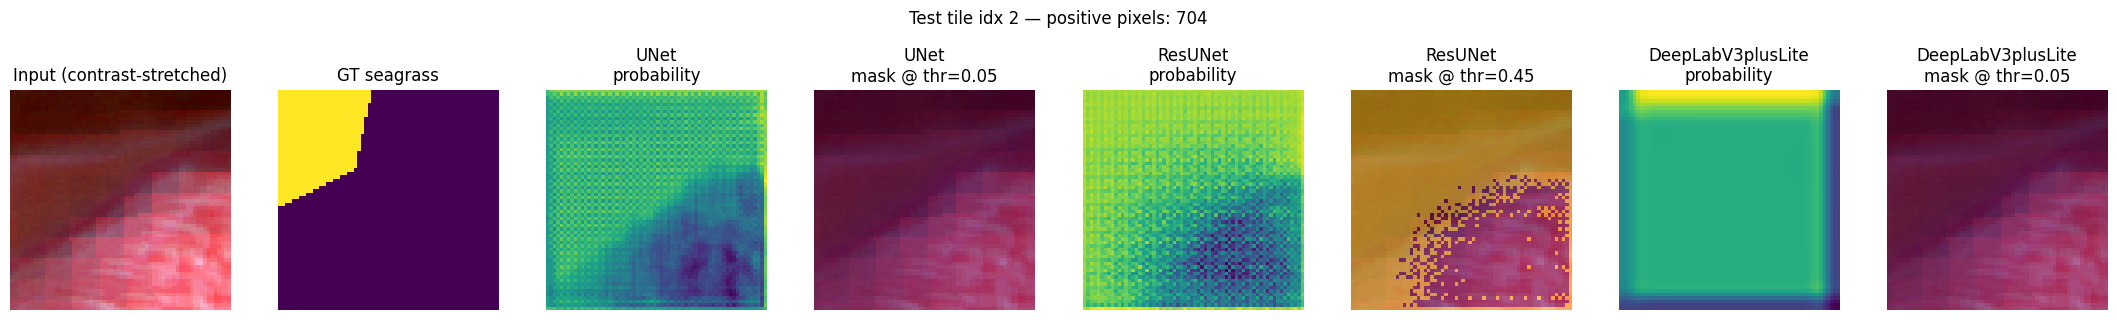

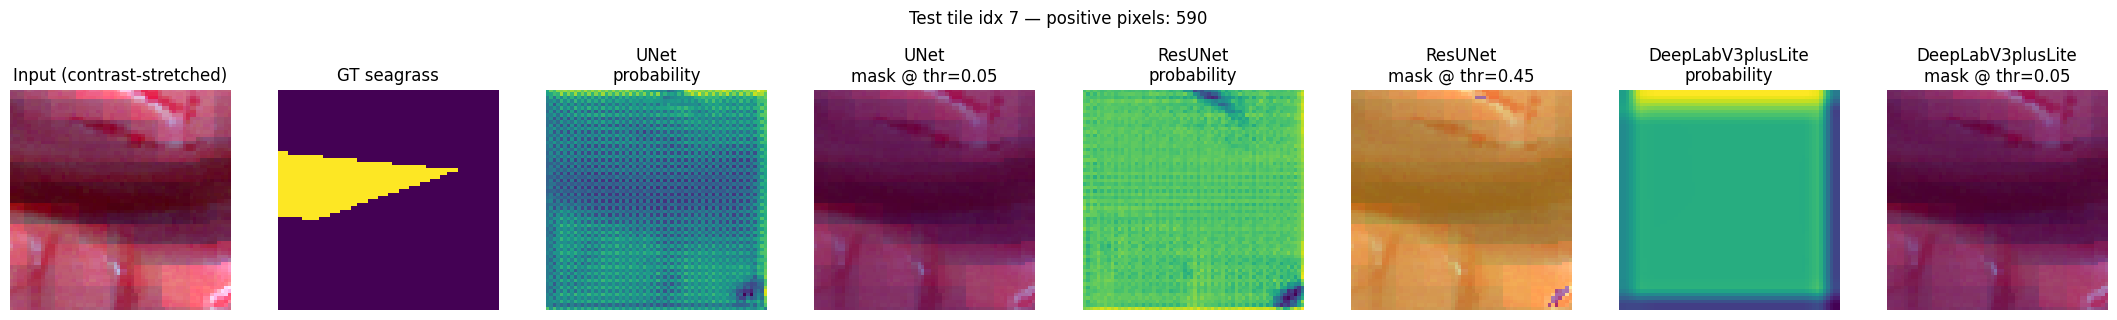

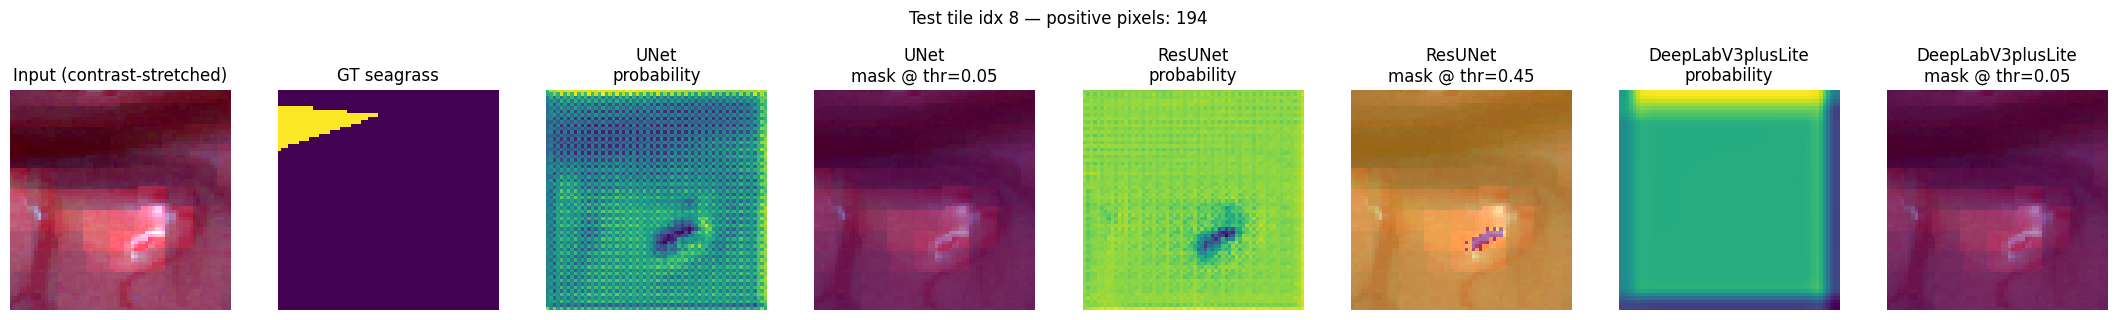

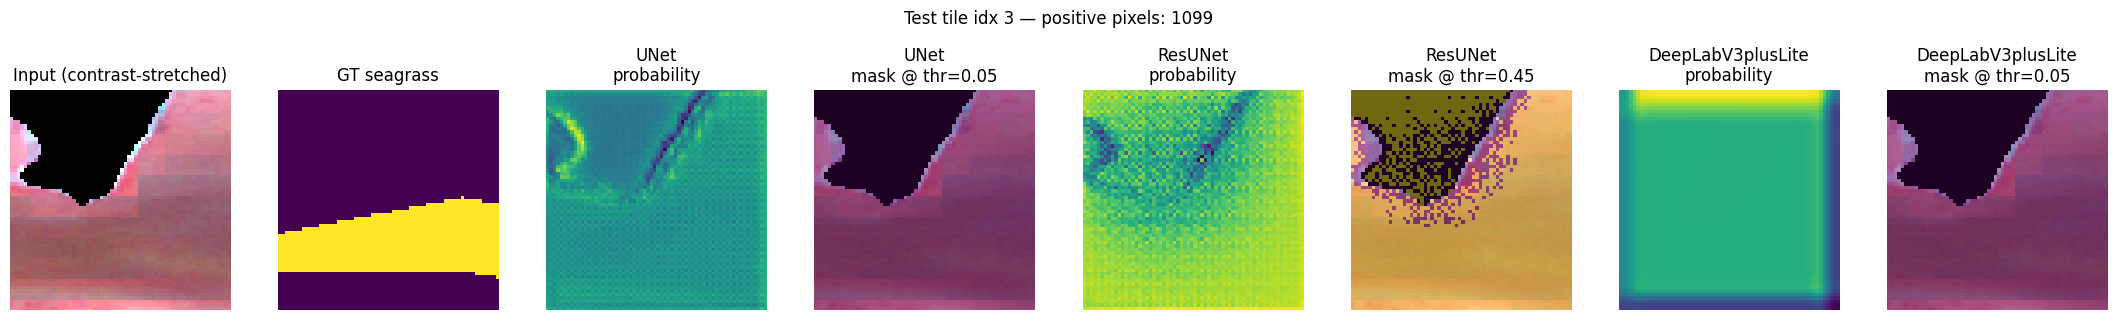

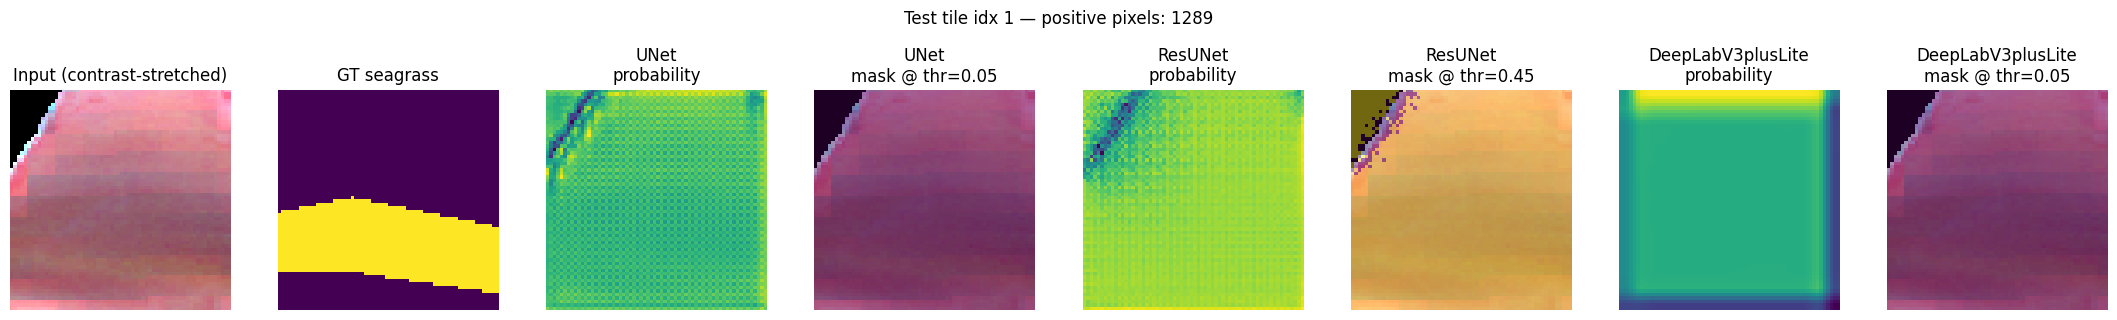

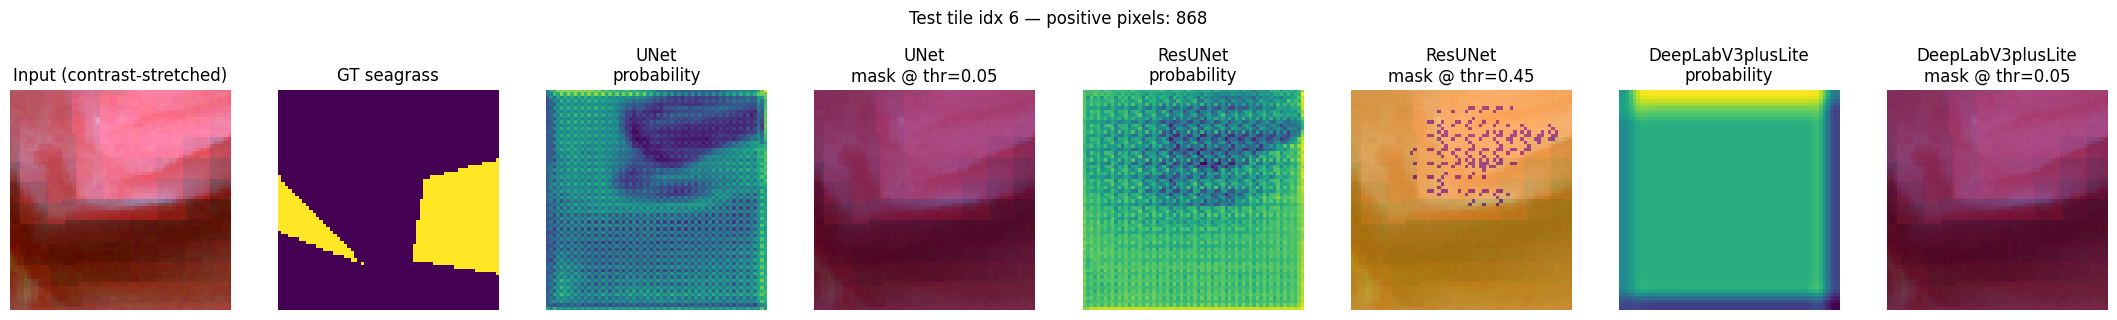

In [ ]:
# === Qualitative gallery: per-tile visualizations (input, GT, probs, masks) ===
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Utility to get a simple 3-channel view from your multi-band chip
def to_rgb(chip):
    """chip: (H,W,C) in [0,1]. Use first 3 channels if available; otherwise tile one band."""
    H,W,C = chip.shape
    if C >= 3:
        rgb = chip[..., :3]
    else:
        rgb = np.repeat(chip[..., :1], 3, axis=-1)
    # contrast stretch for display
    p1, p99 = np.percentile(rgb, [1, 99])
    if p99 > p1:
        rgb = np.clip((rgb - p1)/(p99 - p1), 0, 1)
    else:
        rgb = np.clip(rgb, 0, 1)
    return rgb

# Choose N example tiles (prefer positives), e.g., 6
N = 6
pos_mask = (Yte.reshape(len(Yte), -1).sum(axis=1) > 0)
pos_idx  = np.where(pos_mask)[0]
neg_idx  = np.where(~pos_mask)[0]
rng = np.random.default_rng(0)
pick_pos = rng.choice(pos_idx, size=min(N, len(pos_idx)), replace=False) if len(pos_idx)>0 else np.array([],int)
needed   = max(0, N - len(pick_pos))
pick_neg = rng.choice(neg_idx, size=min(needed, len(neg_idx)), replace=False) if needed>0 else np.array([],int)
sample_idx = np.concatenate([pick_pos, pick_neg])  # positives first, then negatives

# Load all models once
loaded = {name: keras.models.load_model(ck, compile=False) for name, ck in ckpts.items()}

for idx in sample_idx:
    x = Xte[idx]                 # (H,W,C)
    gt = Yte[idx,...,0]          # (H,W)
    rgb = to_rgb(x)

    # Predictions (probs) for each model
    probs = {}
    masks = {}
    for name, mdl in loaded.items():
        pr = mdl.predict(x[None,...], verbose=0)[0,...,0]
        thr = float(val_thresholds[name])
        mk  = (pr >= thr).astype(np.uint8)
        probs[name] = pr
        masks[name] = mk

    # Figure
    ncols = 2 + len(loaded)*2  # RGB, GT, then (prob, mask)*models
    plt.figure(figsize=(2.7*ncols, 3))
    c = 1
    # Input RGB
    plt.subplot(1, ncols, c); c+=1
    plt.imshow(rgb); plt.axis("off"); plt.title("Input (contrast-stretched)")
    # GT
    plt.subplot(1, ncols, c); c+=1
    plt.imshow(gt); plt.axis("off"); plt.title("GT seagrass")

    # For each model: Prob map + Mask overlay
    for name in ["UNet", "ResUNet", "DeepLabV3plusLite"]:
        if name not in probs: # safety
            continue
        pr = probs[name]
        mk = masks[name]

        plt.subplot(1, ncols, c); c+=1
        plt.imshow(pr); plt.axis("off"); plt.title(f"{name}\nprobability")
        plt.subplot(1, ncols, c); c+=1
        plt.imshow(rgb)
        plt.imshow(mk, alpha=0.45)  # overlay mask
        plt.axis("off"); plt.title(f"{name}\nmask @ thr={val_thresholds[name]:.2f}")

    plt.suptitle(f"Test tile idx {idx} — positive pixels: {int(gt.sum())}", y=1.05)
    plt.tight_layout()
    plt.show()


,TP,FP,FN,TN
model,,,,
UNet,7407,54033,0,0
ResUNet,7365,45416,42,8617
DeepLabV3plusLite,7407,54033,0,0


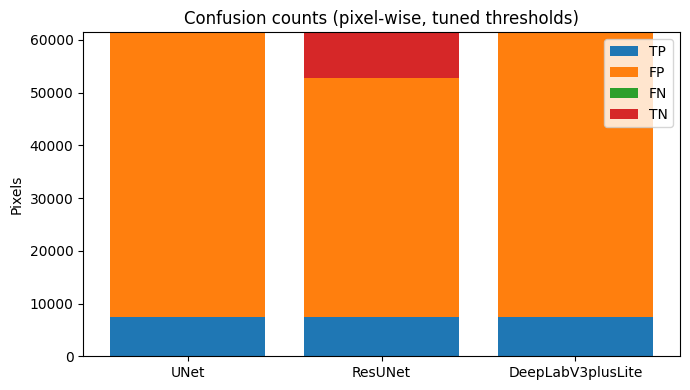

In [ ]:
# Aggregate confusion stats (TP/FP/FN/TN) per model at tuned thresholds

def confusion_counts(y_true_bin, y_prob, thr):
    pm = (y_prob >= thr).astype(np.uint8)
    gt = (y_true_bin > 0.5).astype(np.uint8)
    tp = int((pm & gt).sum())
    fp = int((pm & (1-gt)).sum())
    fn = int(((1-pm) & gt).sum())
    tn = int(((1-pm) & (1-gt)).sum())
    return tp, fp, fn, tn

conf_df = []
# Flatten test GT once
y_true_flat = Yte[...,0].reshape(-1)
for name, ck in ckpts.items():
    mdl = keras.models.load_model(ck, compile=False)
    y_prob = mdl.predict(Xte, batch_size=64, verbose=0)[...,0].reshape(-1)
    thr = float(val_thresholds[name])
    tp, fp, fn, tn = confusion_counts(y_true_flat, y_prob, thr)
    conf_df.append({"model": name, "TP": tp, "FP": fp, "FN": fn, "TN": tn})

conf_df = pd.DataFrame(conf_df).set_index("model")
display(conf_df)

# Stacked bar of confusion components
plt.figure(figsize=(7,4))
bottom = np.zeros(len(conf_df))
for comp in ["TP","FP","FN","TN"]:
    plt.bar(conf_df.index, conf_df[comp].values, bottom=bottom, label=comp)
    bottom += conf_df[comp].values
plt.title("Confusion counts (pixel-wise, tuned thresholds)")
plt.ylabel("Pixels")
plt.legend()
plt.tight_layout()
plt.show()


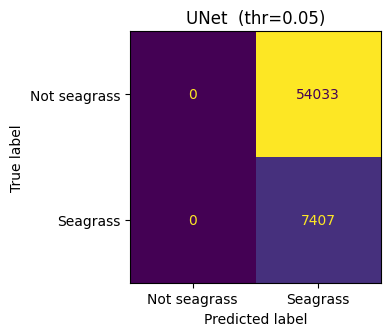

UNet: Prec=0.1206  Rec=1.0000  F1=0.2152  IoU=0.1206


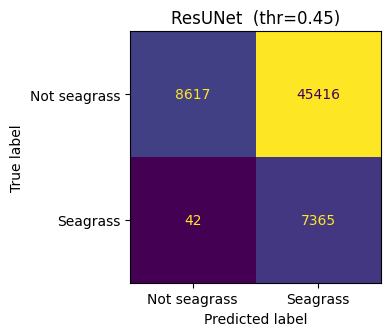

ResUNet: Prec=0.1395  Rec=0.9943  F1=0.2447  IoU=0.1394


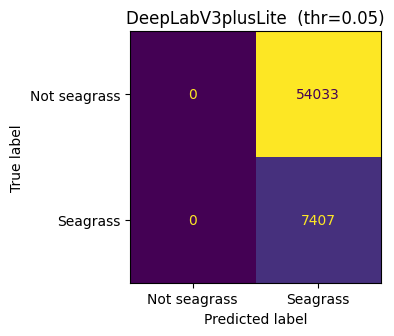

DeepLabV3plusLite: Prec=0.1206  Rec=1.0000  F1=0.2152  IoU=0.1206


In [ ]:
# ==== Confusion matrices for UNet / ResUNet / DeepLabV3plusLite ====
!pip -q install scikit-learn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras

# Fallbacks if not already defined
SEAGRASS_CLASS_ID = globals().get("SEAGRASS_CLASS_ID", 1)
val_thresholds    = globals().get("val_thresholds", {})
ckpts             = globals().get("ckpts", {})

def _predict_probs(ckpt_path, X, batch_size=64):
    mdl = keras.models.load_model(ckpt_path, compile=False)
    pr = mdl.predict(X, batch_size=batch_size, verbose=0)
    # Handle binary vs multi-class
    if pr.ndim == 4 and pr.shape[-1] > 1:
        probs = pr[..., SEAGRASS_CLASS_ID]
    else:
        probs = pr[..., 0]
    return probs

def _confmat_for_model(name, ckpt_path, Xte, Yte, thr=None):
    if thr is None: thr = 0.5
    probs = _predict_probs(ckpt_path, Xte)
    pred  = (probs >= thr).astype(np.uint8).ravel()
    gt    = (Yte[..., 0] > 0.5).astype(np.uint8).ravel()

    # Compute CM
    cm = confusion_matrix(gt, pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    # Plot (separate figure per model)
    fig, ax = plt.subplots(figsize=(4,4))
    disp = ConfusionMatrixDisplay(cm, display_labels=["Not seagrass","Seagrass"])
    disp.plot(ax=ax, colorbar=False)  # no explicit colors
    ax.set_title(f"{name}  (thr={thr:.2f})")
    plt.tight_layout()
    plt.show()

    # Optional quick metrics in text
    precision = tp / (tp + fp + 1e-6)
    recall    = tp / (tp + fn + 1e-6)
    f1        = 2*precision*recall / (precision + recall + 1e-6)
    iou       = tp / (tp + fp + fn + 1e-6)
    print(f"{name}: Prec={precision:.4f}  Rec={recall:.4f}  F1={f1:.4f}  IoU={iou:.4f}")
    return cm

# Run for all three (uses your tuned thresholds if available)
for model_name in ["UNet", "ResUNet", "DeepLabV3plusLite"]:
    if model_name not in ckpts:
        print(f"Skipping {model_name}: checkpoint not found in ckpts dict.")
        continue
    thr = val_thresholds.get(model_name, 0.5)
    _confmat_for_model(model_name, ckpts[model_name], Xte, Yte, thr)


In [ ]:
# ==== Image–pixel overlay: seagrass on base imagery ====
import os, numpy as np, rasterio
from rasterio.enums import Resampling
from rasterio.io import DatasetReader
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
ROOT = globals().get("ROOT", "/content/gdrive/MyDrive/AA_GEOG_proj_training")
OUT_DIR = f"{ROOT}/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

FULL_SCENE_TIF = f"{ROOT}/whanganui_cropped.tif"         # base image (same grid as predictions)
PROB_TIF       = f"{OUT_DIR}/seagrass_coverage_prob.tif"  # probability map (0..1)
CLASS_TIF      = f"{OUT_DIR}/seagrass_coverage_class.tif" # hard mask (0/1), optional

USE_PROB = os.path.exists(PROB_TIF)   # True → use probability; False → use CLASS_TIF
THRESH   = 0.45                       # decision threshold if using probability
# Bands for RGB preview (1-based indices in the FULL_SCENE_TIF)
# For Sentinel-2: common RGB = [B4,B3,B2] → [RED, GREEN, BLUE]; adjust to your band order!
RGB_1BASED = [4, 3, 2]

# Overlay style
OVERLAY_COLOR = np.array([0, 200, 80], dtype=np.uint8)     # seagrass color in the overlay
ALPHA_MAX     = 180                                        # max opacity (0..255)

PNG_OUT  = f"{OUT_DIR}/overlay_preview.png"
RGBA_TIF = f"{OUT_DIR}/seagrass_overlay_rgba.tif"          # transparent RGBA overlay (georeferenced)

# ---------- Helpers ----------
def read_rgb_preview(scene_path: str, rgb_bands_1based):
    with rasterio.open(scene_path) as src:
        bands = []
        for b in rgb_bands_1based:
            bands.append(src.read(b).astype(np.float32))
        rgb = np.stack(bands, axis=0)  # (3,H,W)

        # Percentile stretch per band to 0-255
        rgb_u8 = np.zeros_like(rgb, dtype=np.uint8)
        for i in range(3):
            band = rgb[i]
            lo, hi = np.nanpercentile(band, (2, 98))
            band = np.clip((band - lo) / (hi - lo + 1e-6), 0, 1)
            rgb_u8[i] = (band * 255).astype(np.uint8)
    return np.moveaxis(rgb_u8, 0, -1)  # (H,W,3)

def read_pred_mask(prob_tif, class_tif, use_prob=True, thr=0.5):
    if use_prob and os.path.exists(prob_tif):
        with rasterio.open(prob_tif) as sp:
            prob = sp.read(1).astype(np.float32)
            prof = sp.profile
        mask = (prob >= thr).astype(np.uint8)
        return mask, prob, prof
    elif os.path.exists(class_tif):
        with rasterio.open(class_tif) as sc:
            mask = sc.read(1).astype(np.uint8)
            prof = sc.profile
        prob = mask.astype(np.float32)  # fallback: prob=hard mask
        return mask, prob, prof
    else:
        raise FileNotFoundError("Neither probability nor class prediction rasters were found.")

# ---------- Load data ----------
rgb = read_rgb_preview(FULL_SCENE_TIF, RGB_1BASED)  # (H,W,3)
mask, prob, pred_prof = read_pred_mask(PROB_TIF, CLASS_TIF, USE_PROB, THRESH)

# If shapes differ (shouldn't if created from same scene), resample mask/prob to scene size
with rasterio.open(FULL_SCENE_TIF) as src:
    H, W = src.height, src.width
if mask.shape != (H, W):
    print(f"Resampling prediction from {mask.shape} -> {(H,W)} to match base.")
    # use rasterio.reproject for prob; mask with nearest
    from rasterio.warp import reproject
    prob_rs = np.zeros((H, W), dtype=np.float32)
    reproject(
        source=prob,
        destination=prob_rs,
        src_transform=pred_prof["transform"],
        src_crs=pred_prof["crs"],
        dst_transform=rasterio.open(FULL_SCENE_TIF).transform,
        dst_crs=rasterio.open(FULL_SCENE_TIF).crs,
        resampling=Resampling.bilinear,
    )
    mask = (prob_rs >= THRESH).astype(np.uint8)
    prob = prob_rs

# ---------- Build overlay (RGBA where seagrass pixels get color/alpha, else transparent) ----------
alpha = (prob if USE_PROB else mask.astype(np.float32))
alpha = np.clip(alpha, 0, 1)
alpha_u8 = (alpha * ALPHA_MAX).astype(np.uint8)  # 0..ALPHA_MAX

overlay_rgba = np.zeros((H, W, 4), dtype=np.uint8)
overlay_rgba[..., 0:3] = OVERLAY_COLOR  # color
overlay_rgba[..., 3]   = alpha_u8       # alpha

# ---------- Save georeferenced RGBA overlay (load this on top of the base in GIS) ----------
with rasterio.open(FULL_SCENE_TIF) as base:
    prof = base.profile
rgba_prof = prof.copy()
rgba_prof.update(
    count=4, dtype="uint8", nodata=None,
    photometric='RGB',  # writer will ignore for RGBA but harmless
)

with rasterio.open(RGBA_TIF, "w", **rgba_prof) as dst:
    dst.write(np.moveaxis(overlay_rgba, -1, 0))  # to (4,H,W)
print("Saved:", RGBA_TIF)

# ---------- Make a quick PNG preview (burn overlay into RGB for visualization only) ----------
rgb_f = rgb.astype(np.float32)
ov_f  = OVERLAY_COLOR.astype(np.float32)  # (3,)

# per-pixel alpha blend: out = (1-a)*rgb + a*overlay_color
a = (alpha_u8.astype(np.float32) / 255.0)[..., None]  # (H,W,1)
blended = (1.0 - a) * rgb_f + a * ov_f
blended = np.clip(blended, 0, 255).astype(np.uint8)

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(blended)
plt.tight_layout()
plt.savefig(PNG_OUT, dpi=200, bbox_inches="tight", pad_inches=0)
plt.show()
print("Saved preview:", PNG_OUT)


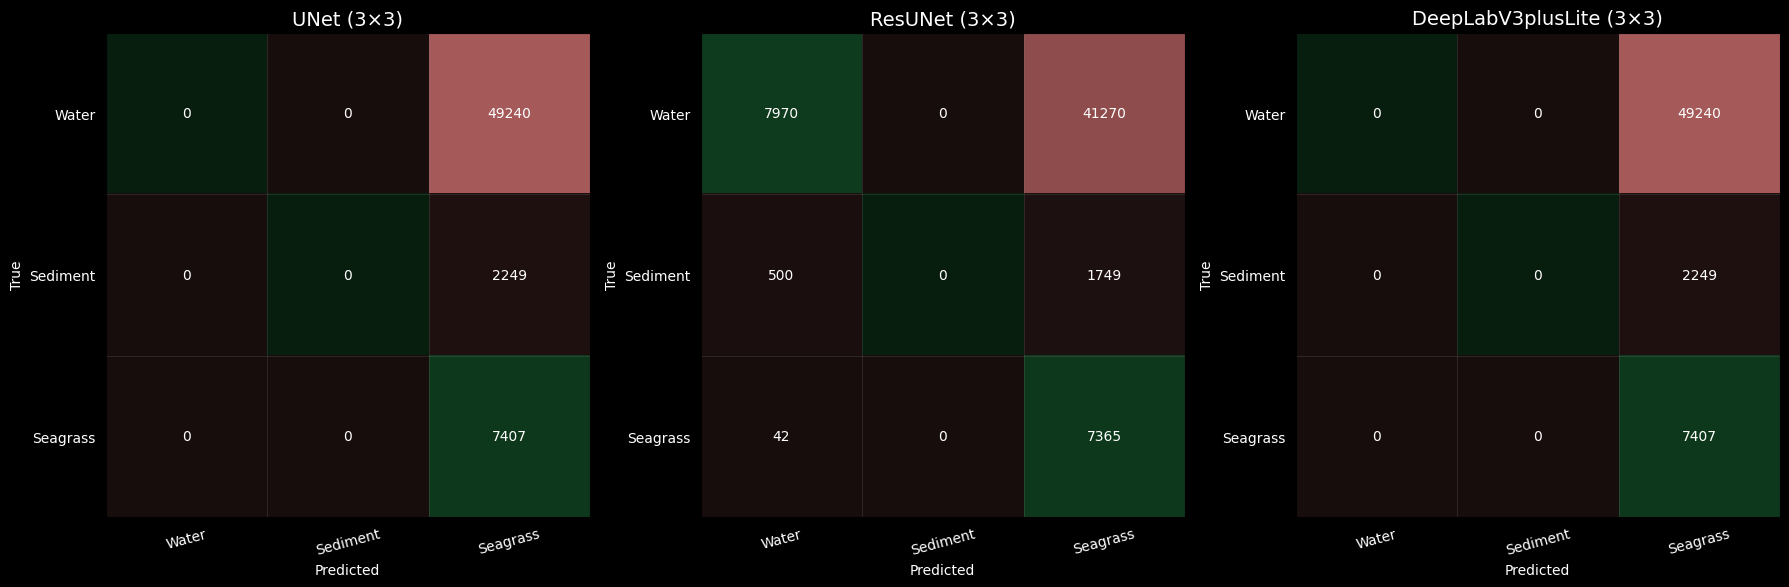

In [ ]:
# ==== 3×3 confusion matrices (Water / Sediment / Seagrass) for UNet / ResUNet / DeepLabV3plusLite ====
!pip -q install scikit-learn
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras

# ---------- CONFIG: map your raw class IDs -> 3 groups ----------
# Put ALL raw ids for each super-class here (edit to your dataset).
GROUPS = {
    "Water":    [0],        # <-- e.g., water ids
    "Sediment": [1, 3],     # <-- e.g., exposed/mud/sand ids
    "Seagrass": [4],        # <-- seagrass ids
}
IGNORE_VALUE = 255          # unlabeled value in ground-truth (if present)
MODEL_ORDER = ["UNet", "ResUNet", "DeepLabV3plusLite"]

# Use your tuned thresholds if you have them
val_thresholds = globals().get("val_thresholds", {})
SEAGRASS_CLASS_ID = globals().get("SEAGRASS_CLASS_ID", 4)  # only used if model is binary

# ---------- helpers ----------
GROUP_NAMES = list(GROUPS.keys())
N_G = 3
raw2group = {}
for gi, ids in enumerate(GROUPS.values()):
    for cid in ids: raw2group[int(cid)] = gi

def remap_to_3(arr):
    """Map raw labels to {0,1,2}; everything else -> 255 (ignore)."""
    out = np.full(arr.shape, 255, dtype=np.int32)
    for raw, gi in raw2group.items():
        out[arr == raw] = gi
    return out

def get_ground_truth_3():
    # Prefer multi-class GT on the test split
    if 'Y_mc' in globals() and 'test_idx' in globals():
        Y_true_raw = Y_mc[test_idx][..., 0].astype(np.int32)
    elif 'Y' in globals() and 'test_idx' in globals():
        Y_true_raw = Y[test_idx].astype(np.int32)
    else:
        raise RuntimeError("Need Y_mc or Y with test_idx present to build a 3×3 confusion matrix.")
    Y3 = remap_to_3(Y_true_raw)
    return Y3

def predict_classes_3(ckpt_path, X, thr=0.5):
    """Return predicted classes mapped to {0,1,2}. Binary models -> 0 (not-seagrass) / 2 (seagrass)."""
    m = keras.models.load_model(ckpt_path, compile=False)
    pr = m.predict(X, batch_size=64, verbose=0)  # (N,H,W,1 or C)
    if pr.shape[-1] == 1:           # binary model
        y_bin = (pr[..., 0] >= thr).astype(np.int32)
        # map: 1 -> Seagrass (2), 0 -> Other (0)  (non-seagrass split can't be recovered from binary model)
        y_pred = np.where(y_bin == 1, 2, 0).astype(np.int32)
    else:                            # multi-class model
        y_raw = np.argmax(pr, axis=-1).astype(np.int32)
        y_pred = remap_to_3(y_raw)
    return y_pred

def draw_cm(ax, cm, title, vmax=None):
    n = cm.shape[0]
    vmax = int(vmax if vmax is not None else max(1, cm.max()))
    norm = cm / max(1, vmax)

    # dark theme; green diagonal, red off-diagonal
    img = np.zeros((n, n, 3), dtype=float)
    green = np.array([0.2, 0.8, 0.4])
    red   = np.array([0.65, 0.35, 0.35])
    for i in range(n):
        for j in range(n):
            base = green if i == j else red
            img[i, j, :] = base * (0.15 + 0.85 * norm[i, j])

    ax.set_facecolor("black")
    ax.imshow(img, interpolation="nearest")
    ax.set_title(title, color="white", fontsize=14)
    ax.set_xlabel("Predicted", color="white")
    ax.set_ylabel("True", color="white")
    ax.set_xticks(np.arange(n)); ax.set_yticks(np.arange(n))
    ax.set_xticklabels(GROUP_NAMES, color="white", rotation=15)
    ax.set_yticklabels(GROUP_NAMES, color="white")

    # grid + counts
    ax.set_xticks(np.arange(-.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n, 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle="-", linewidth=0.5, alpha=0.3)
    for i in range(n):
        for j in range(n):
            ax.text(j, i, str(int(cm[i, j])), ha="center", va="center", color="white", fontsize=10)

# ---------- build & plot ----------
# ground truth mapped to 3 groups
Y3_true = get_ground_truth_3()

# predictions for each model -> 3 groups
cms, vmax = {}, 1
for name in MODEL_ORDER:
    if name not in ckpts:
        print(f"Skipping {name}: no checkpoint in ckpts.")
        continue
    thr = val_thresholds.get(name, 0.5)
    y3_pred = predict_classes_3(ckpts[name], Xte, thr=thr)
    # flatten & ignore unlabeled
    mask = (Y3_true != IGNORE_VALUE)
    cm = confusion_matrix(Y3_true[mask].ravel(), y3_pred[mask].ravel(), labels=[0,1,2])
    cms[name] = cm
    vmax = max(vmax, cm.max())

# one figure with three 3×3 matrices
cols = len(cms)
fig, axes = plt.subplots(1, cols, figsize=(6*cols, 6), facecolor="black")
if cols == 1: axes = [axes]
for ax, name in zip(axes, [m for m in MODEL_ORDER if m in cms]):
    draw_cm(ax, cms[name], f"{name} (3×3)", vmax=vmax)
plt.tight_layout(); plt.show()


In [ ]:
# ==== Five-class confusion matrices for all three models ====
!pip -q install scikit-learn
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras

# ---------- CONFIG ----------
# Set EXACT class ids and (optional) names in your labels:
CLASS_IDS   = [0, 1, 2, 3, 4]                     # <-- edit if your 5 ids differ
CLASS_NAMES = ["0","1","2","3","4"]               # <-- optional pretty names
IGNORE_VALUE = 255                                # unlabeled pixels to ignore
MODEL_ORDER  = ["UNet", "ResUNet", "DeepLabV3plusLite"]

# ---------- helpers ----------
def get_y_true_5():
    """Get multi-class GT for the test split and keep only CLASS_IDS."""
    if 'Y_mc' in globals() and 'test_idx' in globals():
        y = Y_mc[test_idx][..., 0].astype(np.int32)   # (N,H,W)
    elif 'Y' in globals() and 'test_idx' in globals():
        y = Y[test_idx].astype(np.int32)
    else:
        raise RuntimeError("Need multi-class ground truth (Y_mc or Y) and test_idx to make a 5-class matrix.")
    return y

def predict_classes(ckpt_path, X):
    """Returns predicted class ids (N,H,W) from a multi-class model."""
    m = keras.models.load_model(ckpt_path, compile=False)
    pr = m.predict(X, batch_size=64, verbose=0)       # (N,H,W,C)
    if pr.ndim != 4 or pr.shape[-1] < len(CLASS_IDS):
        raise RuntimeError(f"Model output has {pr.shape[-1]} channels — need ≥ {len(CLASS_IDS)} for 5-class CM.")
    return np.argmax(pr, axis=-1).astype(np.int32)

def build_cm(y_true, y_pred, class_ids, ignore=255):
    """Flatten, ignore unlabeled, and compute confusion matrix over class_ids."""
    mask = (y_true != ignore) & np.isin(y_true, class_ids)
    yt = y_true[mask].ravel()
    yp = y_pred[mask].ravel()
    return confusion_matrix(yt, yp, labels=class_ids)

def draw_cm(ax, cm, title, class_names):
    n = cm.shape[0]
    vmax = max(1, cm.max())
    norm = cm / vmax

    # dark theme: green diagonal, red off-diagonal
    img = np.zeros((n, n, 3), dtype=float)
    green = np.array([0.2, 0.8, 0.4])
    red   = np.array([0.65, 0.35, 0.35])
    for i in range(n):
        for j in range(n):
            base = green if i == j else red
            img[i, j, :] = base * (0.15 + 0.85 * norm[i, j])

    ax.set_facecolor("black")
    ax.imshow(img, interpolation="nearest")
    ax.set_title(title, color="white", fontsize=14)
    ax.set_xlabel("Predicted", color="white"); ax.set_ylabel("True", color="white")
    ax.set_xticks(np.arange(n)); ax.set_yticks(np.arange(n))
    ax.set_xticklabels(class_names, color="white", rotation=15)
    ax.set_yticklabels(class_names, color="white")
    ax.set_xticks(np.arange(-.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n, 1), minor=True)
    ax.grid(which="minor", color="gray", linestyle="-", linewidth=0.5, alpha=0.3)
    for i in range(n):
        for j in range(n):
            ax.text(j, i, str(int(cm[i, j])), ha="center", va="center", color="white", fontsize=10)

# ---------- build & plot ----------
Y_true = get_y_true_5()
cms = {}

# collect CMs first (so all panels can share comparable intensity)
for name in MODEL_ORDER:
    if name not in ckpts:
        print(f"Skipping {name}: no checkpoint in ckpts.")
        continue
    y_pred = predict_classes(ckpts[name], Xte)
    cm = build_cm(Y_true, y_pred, CLASS_IDS, ignore=IGNORE_VALUE)
    cms[name] = cm

# one figure with all models
cols = len(cms)
fig, axes = plt.subplots(1, cols, figsize=(6*cols, 6), facecolor="black")
if cols == 1: axes = [axes]
for ax, name in zip(axes, [m for m in MODEL_ORDER if m in cms]):
    draw_cm(ax, cms[name], f"{name} — 5 classes", CLASS_NAMES)
plt.tight_layout(); plt.show()


RuntimeError: Model output has 1 channels — need ≥ 5 for 5-class CM.